## 0. Setup

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


Thu Feb 22 00:01:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              47W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from functools import reduce
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

## 01. Data

In [ ]:
df = pd.read_csv("../tweets.csv")

df = df.drop_duplicates(subset=["text"])

df = df.sample(frac=1)

df = df.reset_index(drop=True)

# replace all words starting with "@" in the 'text' column with "[NAME]"
df['text'] = df['text'].str.replace(r'@\w+', '[NAME]', regex=True)

df['text'] = df['text'].str.replace(r'\s*http://\S+(\s+|$)', '', regex=True).str.strip()

# replace all phone numbers in the 'text' column with "[PHONE]"
df['text'] = df['text'].str.replace(r'(\d{3})[-.\s]?(\d{3})[-.\s]?(\d{4})', '[PHONE]', regex=True)

# get tweet text length
df["text_length"] = df.text.str.len()

# remove meaningless tweet
df = df[df["text_length"]>15]

# drop text_length column
df = df.drop("text_length", axis=1)

df

In [ ]:
import seaborn as sns

sns.set_style('ticks')
sns.set(rc={'figure.figsize':(6,3)})
sns.set(font_scale=1)

g = sns.histplot(data=df, y="category", shrink=0.7)
g.set_xlabel("Count")
g.set_ylabel("Category")

In [ ]:
df_test = df.sample(frac = 0.1)
df_train_val = df.drop(df_test.index)

# rename the dataframes

df = df_train_val
df_prediction = df_test

In [ ]:
# If you want to assign numerical values automatically

df = df[~df.category.str.contains('\|')]
df = df[df.category != 'nocode']
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df.category.replace(label_dict)

df.category.value_counts()

In [ ]:
df.label.value_counts()

### Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size =0.1125,
                                                  random_state = 425, #864 #768 425
                                                  stratify = df.label.values)

In [ ]:
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['category', 'label', 'data_type']).count()

## 02. Loading Tokenizer and Encoding our Data

In [ ]:
!pip install transformers

In [ ]:
from torch.utils.data import TensorDataset
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [ ]:
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

In [ ]:
# Text strings returned to a dictionary with the encoded and processed inputs in the form of PyTorch tensors.

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256, #Inputs that are longer than this are truncated and inputs that are shorter are padded.
    return_tensors='pt' #pytorch tensors
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [ ]:
# Creating PyTorch TensorDataset objects for the training and validation data.

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

### Setting up the RoBERTa Pretrained Model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

### Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 64# parameter1

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

### Setting Up Optimiser and Scheduler


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
lr = 7e-06
eps = 1e-08
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = eps)

In [ ]:
epochs = 16

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## 03. Performance metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

[Argmax function](https://deeplizard.com/learn/video/K3lX3Cltt4c)

In [ ]:
from sklearn.metrics import f1_score

def compute_metrics(preds, labels):
    preds_flat = np.argmax(preds, axis=1)
    labels_flat = labels.flatten()

    label_dict_inverse = {v: k for k, v in label_dict.items()}

    # Compute overall accuracy
    overall_accuracy = (preds_flat == labels_flat).mean()

    # Compute per-class accuracy
    per_class_accuracy = {}
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        per_class_accuracy[label_dict_inverse[label]] = (y_preds == y_true).mean()

    # Compute weighted F1 score
    weighted_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    return overall_accuracy, per_class_accuracy, weighted_f1_score

## 04. Creating a training loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
import random

seed_val = 4
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
epoch_list = []
f1_list = []
acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_RoBERTa_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    overall_accuracy, per_class_accuracy, weighted_f1_score = compute_metrics(predictions, true_vals)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {weighted_f1_score}')
    tqdm.write(f'Accuracy: {overall_accuracy}')

    epoch_list.append(epoch)
    f1_list.append(weighted_f1_score)
    acc_list.append(overall_accuracy)
    train_loss_list.append(loss_train_avg)
    val_loss_list.append(val_loss)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6979742772304095
Validation loss: 0.4647481471300125
F1 Score (Weighted): 0.8254454028698659
Accuracy: 0.8310864393338621


Epoch 2:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4132355805964042
Validation loss: 0.422037111967802
F1 Score (Weighted): 0.8455788450897703
Accuracy: 0.8445678033306899


Epoch 3:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3419231155361885
Validation loss: 0.44072495251893995
F1 Score (Weighted): 0.8375544814476049
Accuracy: 0.8461538461538461


Epoch 4:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2900476536880701
Validation loss: 0.39379721507430077
F1 Score (Weighted): 0.8670599543687678
Accuracy: 0.8683584456780333


Epoch 5:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.24914398865822035
Validation loss: 0.3903368629515171
F1 Score (Weighted): 0.8697872534393498
Accuracy: 0.8723235527359239


Epoch 6:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.21622334602169502
Validation loss: 0.4050272352993488
F1 Score (Weighted): 0.8620838324360075
Accuracy: 0.8636003172085647


Epoch 7:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.18980220924967375
Validation loss: 0.4170766308903694
F1 Score (Weighted): 0.8721216186004919
Accuracy: 0.8723235527359239


Epoch 8:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.16383287432388619
Validation loss: 0.4377089455723763
F1 Score (Weighted): 0.8745394280036636
Accuracy: 0.8762886597938144


Epoch 9:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.14744308024931413
Validation loss: 0.451511362940073
F1 Score (Weighted): 0.8731923777532685
Accuracy: 0.8747026169706582


Epoch 10:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.12665507983034238
Validation loss: 0.46041497886180877
F1 Score (Weighted): 0.879013231440849
Accuracy: 0.8810467882632831


Epoch 11:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.11384418974511135
Validation loss: 0.4754087805747986
F1 Score (Weighted): 0.8722800850831363
Accuracy: 0.8739095955590801


Epoch 12:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.10430945611845416
Validation loss: 0.4821273498237133
F1 Score (Weighted): 0.8754817382116922
Accuracy: 0.8770816812053925


Epoch 13:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.09297555262366167
Validation loss: 0.4840932711958885
F1 Score (Weighted): 0.8765935883290435
Accuracy: 0.8778747026169706


Epoch 14:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.08725397955053128
Validation loss: 0.5057309344410896
F1 Score (Weighted): 0.8733464501063928
Accuracy: 0.8747026169706582


Epoch 15:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.08073633130735312
Validation loss: 0.5094402015209198
F1 Score (Weighted): 0.8767705210914294
Accuracy: 0.8778747026169706


Epoch 16:   0%|          | 0/156 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.07572929578451201
Validation loss: 0.5135170474648476
F1 Score (Weighted): 0.8739752830526585
Accuracy: 0.8754956383822363


In [ ]:
model.load_state_dict(torch.load('/content/finetuned_RoBERTa_epoch_10.model', map_location=torch.device('cpu')))

In [ ]:
df_sum = pd.DataFrame({'F1':f1_list, "Accuracy": acc_list, "train_loss": train_loss_list, "val_loss": val_loss_list, "epoch": epoch_list})

df_sum["learning_rate"] = lr
df_sum["eps"] = eps
df_sum["batch_size"] = batch_size
df_sum

## 05. Testing

In [ ]:
df_test["label"] = df_test.category.replace(label_dict)
df_test["label"] = df_test["label"].astype(int)
df_test["data_type"] = "test"

In [ ]:
df_test

In [ ]:
# Using the tokenizer to encode the test data
encoded_data_test = tokenizer.batch_encode_plus(
    df_test[df_test.data_type=='test'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

# Separating the input_ids, attention_masks and labels from the encoded data

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df_test[df_test.data_type=='test'].label.values)

# Creating a Tensor Dataset from the input_ids, attention_masks and labels
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# Creating a Dataloader from the Tensor Dataset for test data
dataloader_test = DataLoader(dataset_test,
                             sampler=SequentialSampler(dataset_test),
                            batch_size=batch_size)

In [ ]:
_, predictions, true_vals = evaluate(dataloader_test)

In [ ]:
def predicted_list_generate(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    df_label_created = pd.DataFrame()

    predicted = preds_flat.tolist()

    return predicted

prediction = predicted_list_generate(predictions, true_vals)
df_test['predicted_label'] = prediction

In [ ]:
prediction = predicted_list_generate(predictions, true_vals)
df_test['predicted_label'] = prediction

In [ ]:
overall_accuracy, per_class_accuracy, weighted_f1_score = compute_metrics(predictions, true_vals)

print("Overall accuracy:")
print(overall_accuracy)

print("Per Class Accuracy:")
print(per_class_accuracy)

print("weighted_f1_score:")
print(per_class_accuracy)

Overall accuracy:
0.8883534136546185
Per Class Accuracy:
{'Neutral': 0.7359154929577465, 'Positive': 0.9489932885906041, 'Negative': 0.8796296296296297}
weighted_f1_score:
{'Neutral': 0.7359154929577465, 'Positive': 0.9489932885906041, 'Negative': 0.8796296296296297}


## 06. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def conf(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    pred_vals = np.argmax(predictions, axis=1).flatten() # note
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, pred_vals, true_vals

In [ ]:
_, pred_vals, true_vals = conf(dataloader_validation)

cf_matrix = confusion_matrix(true_vals, pred_vals)

In [ ]:
cf_matrix

array([[214,  67,  11],
       [ 25, 705,  22],
       [  6,  19, 192]])

In [ ]:
labels = ["Neutral",  'Positive', "Negative"]
df_cm = pd.DataFrame(cf_matrix, index = labels,
                  columns = labels)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_cm, annot=True,
            linewidths=.5, ax=ax, fmt='g', annot_kws={"fontsize":17})

In [ ]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [ ]:
epoch_csv3 = pd.melt(df_sum, id_vars='epoch', value_vars=['train_loss', "val_loss"])
epoch_csv3.loc[(epoch_csv3.variable == "train_loss"), "variable"] = "Training Loss"
epoch_csv3.loc[(epoch_csv3.variable == "val_loss"), "variable"] = "Validation Loss"

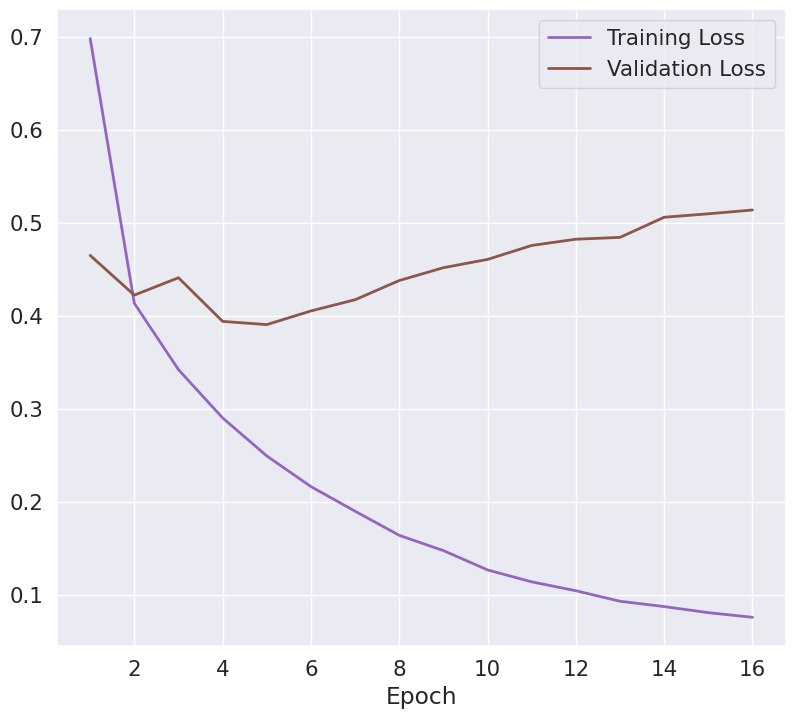

In [ ]:
import seaborn as sns
#sns.set_style('ticks')
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(9.4,8.27)})
sns.set(font_scale=1.4)
g = sns.lineplot(data=epoch_csv3, x="epoch", y="value", hue="variable", palette=[tableau20[8], tableau20[10]], linewidth=2)
g.set_xlabel("Epoch")
g.set_ylabel("")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[0:], labels=labels[0:])